# Model selection and training

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly_express as px
import plotly.graph_objects as go
sns.set()
from pandas.io.json import json_normalize 

In [2]:
# import all what you need for machine learning
import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [3]:
cars = pd.read_csv('./DataFeatures.csv')

In [4]:
cars1 = cars.drop(["city","state",'reviewCount','id','instantBookDisplayed'], axis=1).copy() 

In [5]:
# Separating target variable and its features
y = cars1['averageDailyPrice']
X = cars1.drop('averageDailyPrice',axis=1)

In [6]:
from sklearn.preprocessing import StandardScaler

# define standard scaler
scaler = StandardScaler()
# transform data
cars_main1 = scaler.fit_transform(X)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cars_main1, y, test_size=0.2, random_state=None)
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (29023, 19)
x test:  (7256, 19)
y train:  (29023,)
y test:  (7256,)


In [8]:
#fit decision tree
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
#fit random forest
forest = RandomForestRegressor(n_jobs=-1)
forest.fit(X_train, y_train)
#fit XGBoost
xg_reg = xgb.XGBRegressor(objective ='reg:linear')
xg_reg.fit(X_train, y_train)

[20:53:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

... and then test them on train data, in terms of RMSE:

In [11]:
models= [('XGBoost', xg_reg), ('random forest', forest), ('decision tree', tree)]

for i, model in models:    
    predictions = model.predict(X_train)
    MSE = mean_squared_error(y_train, predictions)
    RMSE = np.sqrt(MSE)
    msg = "%s = %.2f" % (i, round(RMSE, 2))
    print('RMSE of', msg)

RMSE of XGBoost = 42.17
RMSE of random forest = 24.49
RMSE of decision tree = 0.00


Using the Mean absolute percentage error (MAPE) to compute a measure of accuracy

In [12]:
for i, model in models:
    # Make predictions on train data
    predictions = model.predict(X_train)
    # Performance metrics
    errors = abs(predictions - y_train)
    # Calculate mean absolute percentage error (MAPE)
    mape = np.mean(100 * (errors / y_train))
    # Calculate and display accuracy
    accuracy = 100 - mape    
    #print result
    msg = "%s= %.2f"% (i, round(accuracy, 2))
    print('Accuracy of', msg,'%')

Accuracy of XGBoost= 70.49 %
Accuracy of random forest= 86.46 %
Accuracy of decision tree= 100.00 %


Cross-validating the three models and compare them

In [13]:
models= [('XGBoost', xg_reg), ('forest', forest), ('dt', tree)]
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

#for each model I want to test three different scoring metrics. Therefore, results[0] will be lin_reg x MSE, 
# results[1] lin_reg x MSE and so on until results [8], where we stored dt x r2

results= []
metric= []
for name, model in models:
    for i in scoring:
        scores = cross_validate(model, X_train, y_train, scoring=i, cv=10, return_train_score=True)
        results.append(scores)

[20:59:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:59:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:59:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:59:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:59:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscal

In [14]:
#THIS IS FOR XGBoost
#if you change signa and square the Mean Square Error you get the RMSE, which is the most common metric to accuracy
XG_RMSE_mean = np.sqrt(-results[0]['test_score'].mean())
XG_RMSE_std= results[0]['test_score'].std()
# note that also here I changed the sign, as the result is originally a negative number for ease of computation
XG_MAE_mean = -results[1]['test_score'].mean()
XG_MAE_std= results[1]['test_score'].std()
XG_r2_mean = results[2]['test_score'].mean()
XG_r2_std = results[2]['test_score'].std()

#THIS IS FOR RF
RF_RMSE_mean = np.sqrt(-results[3]['test_score'].mean())
RF_RMSE_std= results[3]['test_score'].std()
RF_MAE_mean = -results[4]['test_score'].mean()
RF_MAE_std= results[4]['test_score'].std()
RF_r2_mean = results[5]['test_score'].mean()
RF_r2_std = results[5]['test_score'].std()

#THIS IS FOR DT
DT_RMSE_mean = np.sqrt(-results[6]['test_score'].mean())
DT_RMSE_std= results[6]['test_score'].std()
DT_MAE_mean = -results[7]['test_score'].mean()
DT_MAE_std= results[7]['test_score'].std()
DT_r2_mean = results[8]['test_score'].mean()
DT_r2_std = results[8]['test_score'].std()

In [15]:
modelDF = pd.DataFrame({
    'Model'       : ['XGBoost', 'Random Forest', 'Decision Trees'],
    'RMSE_mean'    : [XG_RMSE_mean, RF_RMSE_mean, DT_RMSE_mean],
    'RMSE_std'    : [XG_RMSE_std, RF_RMSE_std, DT_RMSE_std],
    'MAE_mean'   : [XG_MAE_mean, RF_MAE_mean, DT_MAE_mean],
    'MAE_std'   : [XG_MAE_std, RF_MAE_std, DT_MAE_std],
    'r2_mean'      : [XG_r2_mean, RF_r2_mean, DT_r2_mean],
    'r2_std'      : [XG_r2_std, RF_r2_std, DT_r2_std],
    }, columns = ['Model', 'RMSE_mean', 'RMSE_std', 'MAE_mean', 'MAE_std', 'r2_mean', 'r2_std'])

modelDF.sort_values(by='r2_mean', ascending=False)

,Model,RMSE_mean,RMSE_std,MAE_mean,MAE_std,r2_mean,r2_std
0,XGBoost,63.379163,595.250057,32.626803,1.110255,0.681563,0.023786
1,Random Forest,66.724037,669.808280,33.005630,1.164002,0.648117,0.031674
2,Decision Trees,93.729525,948.130906,41.681378,1.831473,0.292682,0.038185


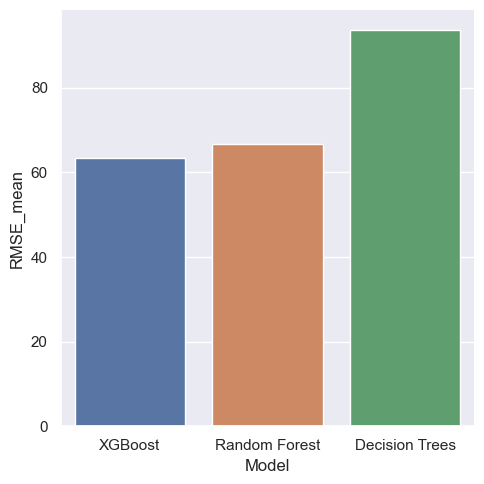

In [16]:
sns.catplot(x= 'Model', y= 'RMSE_mean', data= modelDF, kind='bar', legend='True')

### XGBoost

In [48]:
from sklearn.preprocessing import StandardScaler

#Let's drop the irrelevant columns
cars2 = cars.drop(["city","state",'reviewCount','id',
                   'population','automaticTransmission','newListing','Unnamed: 0'], axis=1).copy() 
# Separating target variable and its features
y2 = cars2['averageDailyPrice']
X2 = cars2.drop('averageDailyPrice',axis=1)

# define standard scaler
scaler = StandardScaler()
# transform data
cars_main2 = scaler.fit_transform(X2)

from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(cars_main2, y2, test_size=0.2, random_state=None)
print("x train: ",X_train2.shape)
print("x test: ",X_test2.shape)
print("y train: ",y_train2.shape)
print("y test: ",y_test2.shape)

x train:  (29023, 16)
x test:  (7256, 16)
y train:  (29023,)
y test:  (7256,)


In [49]:
cars2.head(5) 

,rating,renterTripsTaken,responseRate,freeDeliveryPromotion,instantBookDisplayed,averageDailyPrice,scalar,longitude,latitude,model,make,year,type,listingyear,month,weekday,Listing Difference
0,4.873181,0,0.0,1,1,29.0,11,-93.265547,42.522726,323,18,2014,1,2014,7,0,0
1,5.000000,1,100.0,1,2,162.0,8,-95.789869,44.433663,60,45,2017,1,2018,4,5,1
2,4.873181,0,0.0,1,2,40.0,5,-80.559747,40.351722,222,10,2014,1,2017,9,3,3
3,3.750000,4,100.0,1,2,99.0,19,-80.222071,40.518838,56,6,2006,1,2017,11,3,11
4,4.873181,0,0.0,1,1,81.0,17,-80.241361,40.495285,283,18,2017,3,2018,5,3,1


In [51]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.4, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 100)
xg_reg.fit(X_train2,y_train2)

preds = xg_reg.predict(X_test2)

[21:24:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


Compute the rmse by invoking the mean_sqaured_error function from sklearn's metrics module.

In [52]:
rmse = np.sqrt(mean_squared_error(y_test2, preds))
print("RMSE: %f" % (rmse))

RMSE: 67.909045


## Model evaluation and refinement

**k-fold Cross Validation using XGBoost**

In [53]:
data_dmatrix = xgb.DMatrix(data=X2,label=y2)
params = {"objective":"reg:linear",'colsample_bytree': 0.4,'learning_rate': 0.3,
                'max_depth': 10, 'alpha': 10, 'gamma':5}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=100,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[21:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [54]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,126.480333,1.002390,129.229841,1.452642
1,107.714621,2.368940,112.644547,4.030891
2,97.179817,4.405936,104.168992,5.865278
3,86.461019,3.541541,94.974828,3.340612
4,80.978250,4.176510,91.211862,2.600366


In [55]:
#Extract and print the final boosting round metric.
print((cv_results["test-rmse-mean"]).tail(1))

99    67.765192
Name: test-rmse-mean, dtype: float64


In [56]:
from sklearn.metrics import r2_score
preds_t = xg_reg.predict(X_train2)
r2_score(y_train2,preds_t)

0.9005072752126813

In [57]:
r2_score(y_test2,preds)

0.6500770036342522

**Visualising feature importance**

In [58]:
xg_reg_vis = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[21:25:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


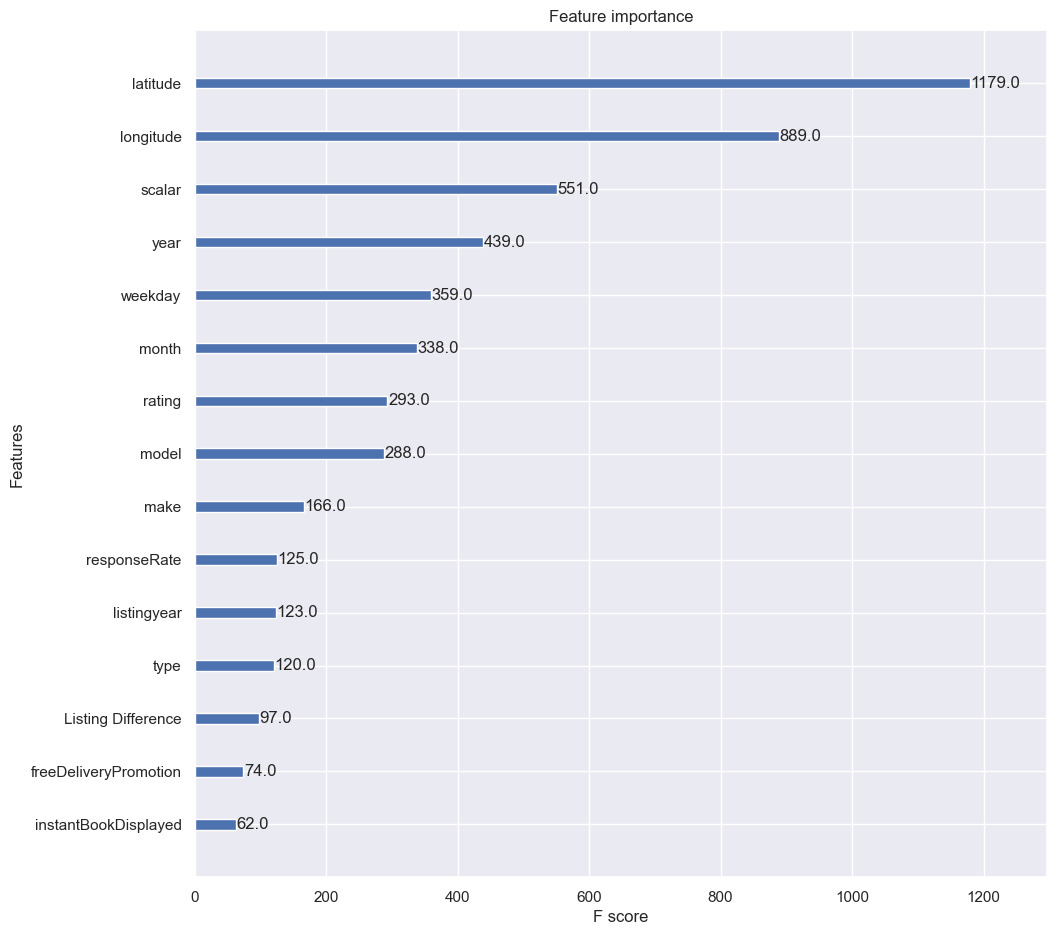

In [59]:
xgb.plot_importance(xg_reg_vis)
plt.rcParams['figure.figsize'] = [11, 11]
plt.show()

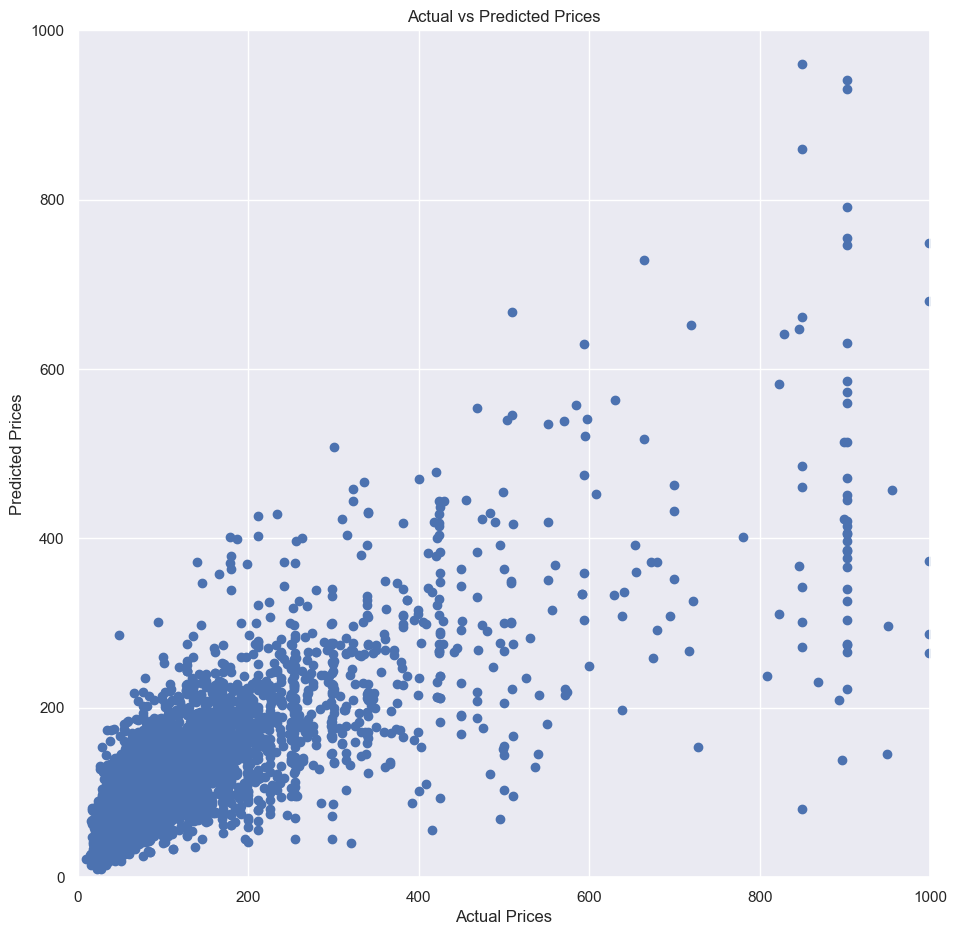

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

# Get predictions from the trained model
preds = xg_reg.predict(X_test2)

# Plot predicted prices vs actual prices
plt.scatter(y_test2, preds)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.show()

In [62]:
import pickle
# Save the model to a file
filename = 'xgboost_model.pkl'
pickle.dump(model, open(filename, 'wb'))